In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt

In [33]:
#pip install datasets

In [34]:
#pip install transformers[torch]

In [35]:
from datasets import load_dataset

In [36]:
reviews = load_dataset("csv", data_files="/kaggle/input/amazon-reviews-dataset/cleaned_reviews.csv", sep=",")

  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
reviews

DatasetDict({
    train: Dataset({
        features: ['sentiments', 'cleaned_review', 'cleaned_review_length', 'review_score'],
        num_rows: 17340
    })
})

In [38]:
train_ds = reviews["train"]
len(train_ds)

17340

In [39]:
train_ds[0]

{'sentiments': 'positive',
 'cleaned_review': 'i wish would have gotten one earlier love it and it makes working in my laptop so much easier',
 'cleaned_review_length': 19,
 'review_score': 5.0}

In [40]:
train_ds.set_format(type="pandas")

In [41]:
train_data = train_ds[:]

In [42]:
train_data = train_data.dropna()

In [43]:
train_data.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


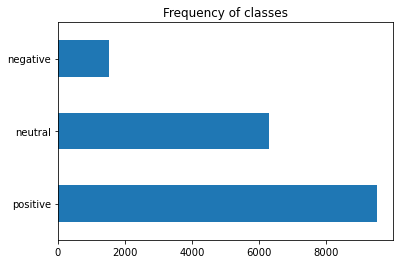

In [44]:
train_data['sentiments'].value_counts(ascending=False).plot.barh()
plt.title("Frequency of classes")
plt.show()

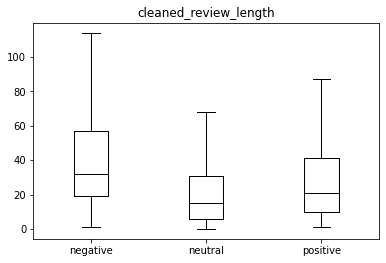

In [45]:
train_data.boxplot("cleaned_review_length", by="sentiments", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [47]:
train_data.drop(['cleaned_review_length', 'review_score'], axis=1, inplace=True)

In [48]:
train_data[['sentiments']] = train_data[['sentiments']].apply(lambda col:pd.Categorical(col).codes)

In [49]:
from datasets import Dataset
train = Dataset.from_pandas(train_data)

In [50]:
train

Dataset({
    features: ['sentiments', 'cleaned_review', '__index_level_0__'],
    num_rows: 17337
})

In [51]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [52]:
def tokenize(batch):
    
    return tokenizer(batch['cleaned_review'], padding=True, truncation=True)

In [53]:
print(tokenize(train[:2]))

{'input_ids': [[101, 1045, 4299, 2052, 2031, 5407, 2028, 3041, 2293, 2009, 1998, 2009, 3084, 2551, 1999, 2026, 12191, 2061, 2172, 6082, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2310, 4342, 2023, 10800, 2153, 2330, 1996, 7427, 1998, 2224, 1996, 4031, 2157, 2185, 3641, 2023, 8000, 1999, 2257, 2004, 2026, 3604, 8000, 1998, 2074, 8966, 2009, 2185, 1999, 2026, 4524, 2085, 2310, 2042, 5873, 2155, 1999, 1996, 1052, 2078, 2860, 2144, 3054, 2244, 1996, 8000, 2165, 3715, 1998, 2499, 2986, 2005, 3232, 1997, 3134, 2044, 28667, 8167, 5999, 1996, 8000, 2009, 2499, 2005, 2154, 2030, 2048, 1998, 2059, 7024, 2000, 3853, 1996, 9380, 2422, 2097, 5956, 2320, 2043, 2357, 2006, 2059, 2498, 1997, 2607, 1996, 2709, 3332, 2003, 2092, 2627, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [54]:
emotions_encoded = train.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [55]:
print(emotions_encoded.column_names)

['sentiments', 'cleaned_review', '__index_level_0__', 'input_ids', 'attention_mask']


# Using Transformers as feature extractors for text classification

In [56]:
import torch
import torch.nn.functional as F

In [57]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [59]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
 outputs = model(**inputs)
print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [60]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

[batch_size, n_tokens, hidden_dim]

just the CLS token

In [61]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [62]:
emotions_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "sentiments"])

In [63]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [64]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=128)

  0%|          | 0/136 [00:00<?, ?ba/s]

In [65]:
emotions_hidden.column_names

['sentiments',
 'cleaned_review',
 '__index_level_0__',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [66]:
X = np.array(emotions_hidden['hidden_state'])

In [67]:
np.save('/kaggle/working/hidden.npy', X)

In [68]:
y = np.array(emotions_hidden['sentiments'])

In [69]:
np.save('/kaggle/working/labels.npy', y)

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [73]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.5493079584775087

In [72]:
from sklearn.linear_model import LogisticRegression
# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.8021914648212226

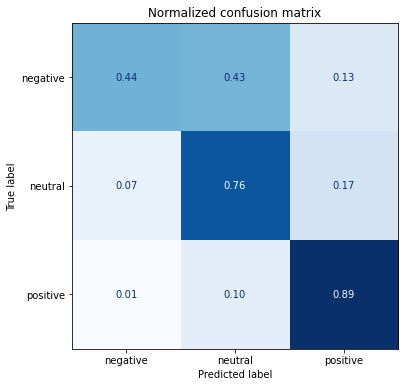

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()
y_preds = lr_clf.predict(X_test)
plot_confusion_matrix(y_preds, y_test, ["negative", "neutral", "positive"])
